**Qiskit Density Matrix**

In [10]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import DensityMatrix, Kraus
from qiskit_aer import AerSimulator
import numpy as np

T1 = 10 ** -4
n_qubits = 1
exact_params = []
np_taus = [10**-6, 10**-5, 5*10**-5, 10**-4]#, 1.5 * 10**-4]  # np.linspace(10**-6, 10**-4, num=10)
taus = [round(float(tau), 8) for tau in np_taus]
print(taus)
T2 = np.arange(T1/10, 2*T1 + T1/10, T1/10)
T0 = T1*10
for tau in taus:  
    exact_rho = []
    for T in T2:
        lam = 1/T - 1/(2*T1)
        p_exc = 1-np.exp(-tau/T0)
        p_amp = 1-np.exp(-tau/T1)
        p_phase = 1-np.exp(-lam*tau)

        #Kraus

        #Amplitude excitation (T1)
        K1_exc = np.array([[np.sqrt(1 - p_exc), 0], [0, 1]])
        K2_exc = np.array([[0, 0], [np.sqrt(p_exc), 0]])
        amp_exc = Kraus([K1_exc, K2_exc])

        #Amplitude damping (T1)
        K1_amp = np.array([[1, 0], [0, np.sqrt(1 - p_amp)]])
        K2_amp = np.array([[0, np.sqrt(p_amp)], [0, 0]])
        amp_damping = Kraus([K1_amp, K2_amp])

        #Phase damping (T2)
        # K1_phase = np.array([[np.sqrt(1 - p_phase), 0], [0, np.sqrt(1 - p_phase)]])
        # K2_phase = np.array([[np.sqrt(p_phase), 0], [0, -np.sqrt(p_phase)]])

        #N&C
        # K1_phase = np.array([[1, 0], [0, np.sqrt(1 - p_phase)]])
        # K2_phase = np.array([[0, 0], [0, np.sqrt(p_phase)]])
        # phase_damping = Kraus([K1_phase, K2_phase])

        #Preskill
        K1_phase = np.array([[np.sqrt(1 - p_phase), 0], [0, np.sqrt(1 - p_phase)]])
        K2_phase = np.array([[np.sqrt(p_phase), 0], [0, 0]])
        K3_phase = np.array([[0, 0], [0, np.sqrt(p_phase)]])
        phase_damping = Kraus([K1_phase, K2_phase, K3_phase])

        # #Combined operators
        # K1_comb = np.array([[1, 0], [0, np.sqrt(1 - p_amp) * np.sqrt(1 - p_phase)]])
        # K2_comb = np.array([[0, np.sqrt(p_amp)], [0, 0]])
        # K3_comb = np.array([[0, 0], [0, np.sqrt(1 - p_amp) * np.sqrt(p_phase)]])
        # comb_damping = Kraus([K1_comb, K2_comb, K3_comb])


        #Circuit

        qc = QuantumCircuit(n_qubits)

        #GHZ
        qc.h(0)
        
        for q in range(n_qubits-1):
            qc.cx(q, q+1)

        #Add decoherence
        for qubit in range(n_qubits):
            qc.append(amp_exc.to_instruction(), [qubit])
            qc.append(amp_damping.to_instruction(), [qubit])
            qc.append(phase_damping.to_instruction(), [qubit])
            # qc.append(comb_damping.to_instruction(), [qubit])

        qc.save_density_matrix()

        sim = AerSimulator(method='density_matrix')

        result = sim.run(qc).result()

        rho = np.array(result.data(0)['density_matrix'])
        # print("Final density matrix with manual gamma lambda noise:\n", DensityMatrix(rho))
        exact_rho.append(rho)

    exact_params.append(exact_rho)


[1e-06, 1e-05, 5e-05, 0.0001]


**Statevector**

In [11]:
'''
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Kraus, DensityMatrix
import numpy as np

# Parameters
T1 = 10 ** -5
n_qubits = 1
num_shots = 1000  # Number of noisy samples
statevector_params = []

np_taus = np.linspace(10**-6, 10**-5, num=10)
taus = [round(float(tau), 16) for tau in np_taus]
T2 = np.arange(T1/10, 2*T1, T1/10)

# Simulate each tau
for tau in taus:  
    exact_rho = []
    for T in T2:
        lam = 1/T - 1/(2*T1)
        p_amp = 1 - np.exp(-tau/T1)
        p_phase = 1 - np.exp(-2*lam*tau)

        # Define Kraus operators
        # Amplitude damping
        K1_amp = np.array([[1, 0], [0, np.sqrt(1 - p_amp)]])
        K2_amp = np.array([[0, np.sqrt(p_amp)], [0, 0]])
        amp_damping = [K1_amp, K2_amp]

        # Phase damping
        K1_phase = np.array([[np.sqrt(1 - p_phase), 0], [0, np.sqrt(1 - p_phase)]])
        K2_phase = np.array([[np.sqrt(p_phase), 0], [0, -np.sqrt(p_phase)]])
        phase_damping = [K1_phase, K2_phase]

        # Base state preparation
        qc = QuantumCircuit(n_qubits)
        qc.h(0)  # You can add more gates here (e.g., entangling)
        psi = Statevector(qc)

        # Noisy sampling
        noisy_density = np.zeros((2, 2), dtype=complex)

        for _ in range(num_shots):
            # Start from same state
            noisy_psi = psi

            # Sample amplitude damping Kraus
            probs = [
                np.linalg.norm(amp_damping[0] @ noisy_psi.data) ** 2,
                np.linalg.norm(amp_damping[1] @ noisy_psi.data) ** 2
            ]
            probs = np.array(probs)
            probs /= np.sum(probs)
            k_amp = amp_damping[np.random.choice([0, 1], p=probs)]


            # Sample phase damping Kraus
            # Compute and normalize probabilities
            probs = [
                np.linalg.norm(phase_damping[0] @ noisy_psi.data) ** 2,
                np.linalg.norm(phase_damping[1] @ noisy_psi.data) ** 2
            ]
            probs = np.array(probs)
            probs /= np.sum(probs)  # normalize to sum to 1

            # Sample Kraus operator
            k_phase = phase_damping[np.random.choice([0, 1], p=probs)]


            # Accumulate outer product
            noisy_density += np.outer(noisy_psi.data, np.conj(noisy_psi.data))

        # Normalize to form approximate density matrix
        noisy_density /= num_shots
        exact_rho.append(noisy_density)

    statevector_params.append(exact_rho)

print(T2)
'''

'\nfrom qiskit import QuantumCircuit\nfrom qiskit.quantum_info import Statevector, Kraus, DensityMatrix\nimport numpy as np\n\n# Parameters\nT1 = 10 ** -5\nn_qubits = 1\nnum_shots = 1000  # Number of noisy samples\nstatevector_params = []\n\nnp_taus = np.linspace(10**-6, 10**-5, num=10)\ntaus = [round(float(tau), 16) for tau in np_taus]\nT2 = np.arange(T1/10, 2*T1, T1/10)\n\n# Simulate each tau\nfor tau in taus:  \n    exact_rho = []\n    for T in T2:\n        lam = 1/T - 1/(2*T1)\n        p_amp = 1 - np.exp(-tau/T1)\n        p_phase = 1 - np.exp(-2*lam*tau)\n\n        # Define Kraus operators\n        # Amplitude damping\n        K1_amp = np.array([[1, 0], [0, np.sqrt(1 - p_amp)]])\n        K2_amp = np.array([[0, np.sqrt(p_amp)], [0, 0]])\n        amp_damping = [K1_amp, K2_amp]\n\n        # Phase damping\n        K1_phase = np.array([[np.sqrt(1 - p_phase), 0], [0, np.sqrt(1 - p_phase)]])\n        K2_phase = np.array([[np.sqrt(p_phase), 0], [0, -np.sqrt(p_phase)]])\n        phase_dampi

**STAB Sim Decomposition**


In [12]:
import subprocess
import numpy as np

stab_params = []

# Compile the C++ program
compile_result = subprocess.run(
        ["g++", "-std=c++20", "combined_channel.cpp", "-o", "combined_channel"],
        capture_output=True, text=True
    )
if compile_result.returncode != 0:
        print("Compilation failed:")
        print(compile_result.stderr)

for tau in taus:
    density_matrices = []
    for T in T2:
        lines = []
        rhos = []
        with subprocess.Popen(
            ["./combined_channel", str(n_qubits), str(tau), str(T0), str(T1), str(T), str(1000)],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,
            bufsize=1
        ) as proc:
            for line in proc.stdout:
                # print(line, end="")  
                lines.append(line.strip())

            # Wait for process to finish
            proc.wait()

            if proc.returncode != 0:
                error_output = proc.stderr.read()
                print("Runtime Error:")
                print(error_output)
        i = 0
        while i < len(lines):
            if lines[i].startswith("T2="):
                T = float(lines[i].split("=")[1])
                i += 1
                data = list(map(float, lines[i].strip().split()))
                complex_vals = [complex(data[j], data[j+1]) for j in range(0, len(data), 2)]
                dim = int(len(complex_vals)**0.5)
                rho = np.array(complex_vals).reshape((dim, dim))
                rhos.append(rho)
            # elif lines[i].startswith("Time="):
            #     stab_time += float(lines[i].split("=")[1])
            i += 1
                    
        density_matrices.extend(rhos)
    stab_params.append(density_matrices)

**STAB Sim Graph**

20
20


/var/folders/ch/b9nk2s4s0wd77l2b780z9wdh0000gn/T/ipykernel_17109/1243983280.py:21: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  inner = sqrtm(sqrt_rho @ sigma @ sqrt_rho)
/Users/garn195/Library/CloudStorage/OneDrive-PNNL/Project_Repositories/NWQ-Sim/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/garn195/Library/CloudStorage/OneDrive-PNNL/Project_Repositories/NWQ-Sim/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


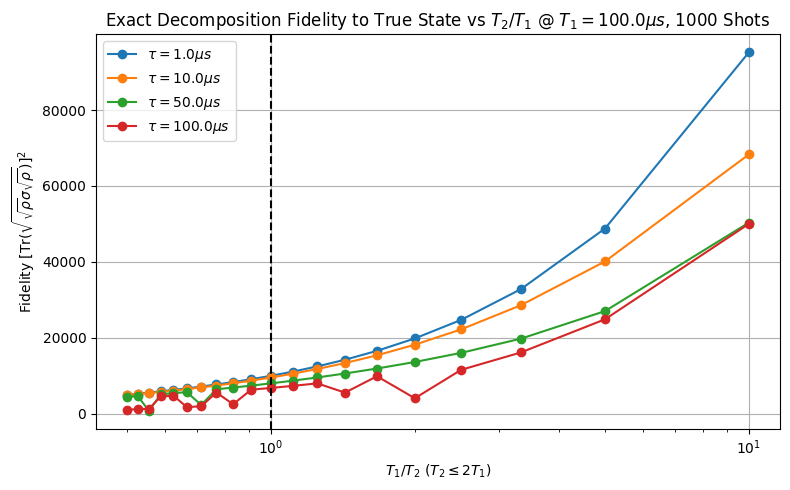

In [13]:
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm

# def clean_density_matrix(rho, eps=1e-12):
#     """Stabilize a nearly-valid density matrix."""
#     rho = (rho + rho.conj().T) / 2  # Enforce Hermitian
#     eigvals, eigvecs = np.linalg.eigh(rho)
#     eigvals = np.clip(eigvals, eps, None)  # Avoid zero or negative eigenvalues
#     rho = eigvecs @ np.diag(eigvals) @ eigvecs.conj().T
#     return rho / np.trace(rho)

# def stable_sqrtm(mat):
#     """Stable square root of a matrix, forcing Hermitian output."""
#     sqrt = sqrtm(mat)
#     if np.any(np.isnan(sqrt)) or np.any(np.isinf(sqrt)):
#         raise ValueError("sqrtm failed: produced NaNs or infs.")
#     return (sqrt + sqrt.conj().T) / 2  # Hermitian

def fidelity(rho, sigma):
    sqrt_rho = sqrtm(rho)
    inner = sqrtm(sqrt_rho @ sigma @ sqrt_rho)
    fid = (np.trace(inner)) ** 2
    return fid

# Assuming true_dms and approx_dms are already defined
# print(density_matrices)
# print(exact_rho)

tau_fidelities = []

# f = fidelity(exact_rho[.001], density_matrices[.001])
print(len(stab_params[0]))
print(len(exact_params[0]))
for i in range(len(taus)):
    fidelities = []
    for j in range(len(T2)):
        rho = np.real(exact_params[i][j])
        sigma = np.real(stab_params[i][j])
        f = fidelity(rho, sigma)
        fidelities.append(f)
    tau_fidelities.append(fidelities)

# print(exact_rho)
# print(density_matrices)
# print(tau_fidelities[0])

# Plot
plt.figure(figsize=(8, 5))

for i, fidelities in enumerate(tau_fidelities):
    plt.plot(T1/np.array(T2) , fidelities, marker='o', label=fr'$\tau = {round(10**6*taus[i], 2)}\mu s$')

plt.plot()

plt.axvline(x=1, color='black', linestyle='--')
plt.xscale('log')

plt.xlabel(r'$T_1/T_2$ ($T_2 \leq 2T_1$)')
plt.ylabel(r'Fidelity $[\mathrm{Tr}(\sqrt{\sqrt{\rho}\sigma\sqrt{\rho}})]^2$')
plt.title(rf'Exact Decomposition Fidelity to True State vs $T_2/T_1$ @ $T_1 ={10**6*T1}\mu s$, 1000 Shots')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
#check diamond norm